In [47]:
import pickle
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
from captum.attr import (
    DeepLift,
    FeatureAblation,
    GradientShap,
    IntegratedGradients,
    NoiseTunnel,
    Occlusion,
)
from spender.data.desi import DESI

from outlier_attribution.model import OutlierModel

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
weight_dir = "/scratch/gpfs/js5013/programs/outlier-attribution/weights"
model = OutlierModel.from_weights(
    f"{weight_dir}/spender.desi-edr.galaxyae-b9bc8d12.pt",
    f"{weight_dir}/galaxy-flow-state_dict.pt",
).to(device)

In [4]:
with open("../data/DESI_EDR_top200_outliers.pkl", "rb") as f:
    data = pickle.load(f)

spectra = torch.tensor(np.stack([data[i]["spectrum"] for i in range(1, 201)])).to(
    device
)

In [29]:
ig = IntegratedGradients(model)
ig_nt = NoiseTunnel(ig)
dl = DeepLift(model)
fa = FeatureAblation(model)
oc = Occlusion(model)

In [32]:
ig_attr = ig.attribute(spectra[:1], n_steps=50)
ig_nt_attr = ig_nt.attribute(spectra[:1])
dl_attr = dl.attribute(spectra[:1])
fa_attr = fa.attribute(spectra[:1])
oc_attr = oc.attribute(spectra[:1], sliding_window_shapes=(16,))

In [33]:
attributions = torch.stack([ig_attr, ig_nt_attr, dl_attr, fa_attr, oc_attr])

RuntimeError: stack expects each tensor to be equal size, but got [2, 7781] at entry 0 and [1, 7781] at entry 1

In [41]:
attribution_labels = [
    "Integrated Gradients",
    "Noise Tunnel",
    "DeepLift",
    "Feature Ablation",
    "Occlusion",
]

Text(0.5, 0, 'Wavelength (A)')

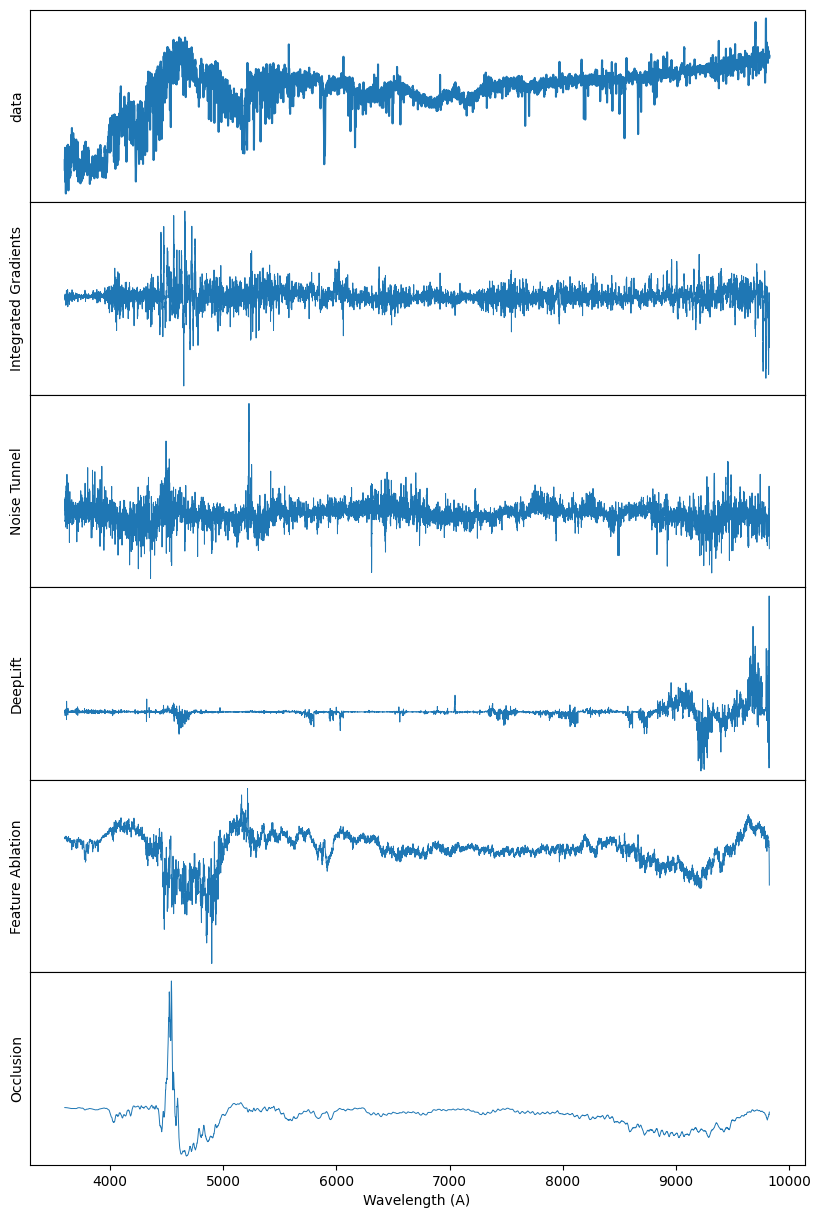

In [63]:
fig, ax = plt.subplots(6, 1, figsize=(10, 15), sharex=True, gridspec_kw=dict(hspace=0))

ax[0].plot(
    DESI._wave_obs,
    (spectra[0]).detach().cpu().numpy(),
)
[
    ax[j + 1].plot(
        DESI._wave_obs,
        attributions[j, 0].detach().cpu().numpy(),
        label=attribution_labels[j],
        lw=0.7,
    )
    for j in range(5)
]
ax[0].set_ylabel("data")
[ax[j + 1].set_ylabel(attribution_labels[j]) for j in range(5)]
for a in ax:
    a.set_yticks([])
# plt.legend(fontsize=12)
plt.xlabel("Wavelength (A)")